In [1]:
import os
import csv
import array
import base64
import xmltodict
import numpy as np

__author__ = "Will Hewitt"
__credits__ = ["Will Hewitt"]
__version__ = "1.0.0"
__maintainer__ = "Will Hewitt"
__email__ = "me@hewittwill.com"
__status__ = "Development"

class ECGXMLReader:
    """Extract voltage data from an ECG XML file."""
    
    def __init__(self, path, augmentLeads=False):
        """
        Initialize the ECGXMLReader object by parsing the provided XML file.
        
        Parameters:
            path (str): The path to the ECG XML file.
            augmentLeads (bool): Whether to generate augmented leads (e.g., III, aVR, aVL, aVF).
        """
        try:
            # Open the XML file in binary mode and decode its content
            with open(path, 'rb') as xml:
                self.ECG = xmltodict.parse(xml.read().decode('utf8'))  # Parse the XML to a Python dictionary
            
            # Store parameters
            self.augmentLeads = augmentLeads
            self.path = path

            # Extract major sections of the ECG file for easier access
            self.PatientDemographics = self.ECG.get('RestingECG', {}).get('PatientDemographics', None)
            self.Diagnosis = self.ECG.get('RestingECG', {}).get('Diagnosis', None)
            self.TestDemographics = self.ECG.get('RestingECG', {}).get('TestDemographics', None)
            self.RestingECGMeasurements = self.ECG.get('RestingECG', {}).get('RestingECGMeasurements', None)

            # Handle 'Waveform' field, which may be missing
            waveform_data = self.ECG.get('RestingECG', {}).get('Waveform', None)
            if waveform_data is None:
                raise KeyError("'Waveform' key is missing in the provided ECG file.")
            
            # Ensure 'Waveform' is a list for consistent processing
            self.Waveforms = waveform_data if isinstance(waveform_data, list) else [waveform_data]

            # Process lead voltage data
            self.LeadVoltages = self.makeLeadVoltages()
        
        except Exception as e:
            print(f"Error initializing ECGXMLReader: {str(e)}")
            self.Waveforms = None  # Set to None if initialization fails
            self.LeadVoltages = None
    
    def makeLeadVoltages(self):
        """
        Extract voltage data for each lead from the ECG data.
        
        Returns:
            dict: A dictionary where keys are lead IDs (e.g., 'I', 'II') and values are arrays of voltage data.
        """
        if not self.Waveforms:
            print("No waveform data available to process.")
            return {}

        num_leads = 0  # Counter for the number of leads
        leads = {}  # Dictionary to store lead voltage data

        # Iterate through all waveform data in the 'Waveforms' list
        for waveform in self.Waveforms:
            if 'LeadData' not in waveform:
                print("Warning: 'LeadData' not found in waveform")
                continue  # Skip waveforms without lead data

            # Iterate through each lead in 'LeadData'
            for lead in waveform['LeadData']:
                num_leads += 1  # Increment the lead counter
                
                # Decode the waveform data (base64 encoded)
                lead_data = lead['WaveFormData']
                lead_b64 = base64.b64decode(lead_data)
                lead_vals = np.array(array.array('h', lead_b64))  # Convert to a NumPy array
                
                # Map the lead ID to its voltage data
                leads[lead['LeadID']] = lead_vals
        
        # If only 8 leads are provided, calculate augmented leads if required
        if num_leads == 8 and self.augmentLeads:
            leads['III'] = np.subtract(leads['II'], leads['I'])  # Calculate lead III
            leads['aVR'] = np.add(leads['I'], leads['II']) * (-0.5)  # Calculate lead aVR
            leads['aVL'] = np.subtract(leads['I'], 0.5 * leads['II'])  # Calculate lead aVL
            leads['aVF'] = np.subtract(leads['II'], 0.5 * leads['I'])  # Calculate lead aVF
        
        return leads

    def getLeadVoltages(self, LeadID):
        """
        Get the voltage data for a specific lead.
        
        Parameters:
            LeadID (str): The ID of the lead (e.g., 'I', 'II').
        
        Returns:
            np.array or None: The voltage data for the specified lead, or None if the lead is not found.
        """
        return self.LeadVoltages.get(LeadID, None) if self.LeadVoltages else None
    
    def getAllVoltages(self):
        """
        Get the voltage data for all leads.
        
        Returns:
            dict: A dictionary containing voltage data for all available leads.
        """
        return self.LeadVoltages if self.LeadVoltages else {}



In [2]:
#Use the class to read the ECG XML file
file_name = 'OKARYS.xml'
folder = r'C:\Users\Antonio\Documents\VisualStudioCode\ECGXMLReader'

ecg = ECGXMLReader(os.path.join(folder, file_name), augmentLeads=True)

#Just for testing:
# #Get the voltage data for lead I
# lead_I = ecg.getLeadVoltages('I')

# #Plot the voltage data for lead I
# import matplotlib.pyplot as plt
# plt.plot(lead_I)
# plt.show()

#Get data for all leads
all_leads = ecg.getAllVoltages()

#Convert to a numpy array
import numpy as np
all_leads_np = np.array(list(all_leads.values()))
print(all_leads_np.shape) #This should be (12, 5000) for 12 leads and 5000 samples


(12, 5000)


In [3]:
#Save the data to a numpy file with the same file_name
np_file_name = file_name.replace('.xml', '.npy')
np_folder = folder

np.save(os.path.join(np_folder,np_file_name), all_leads)

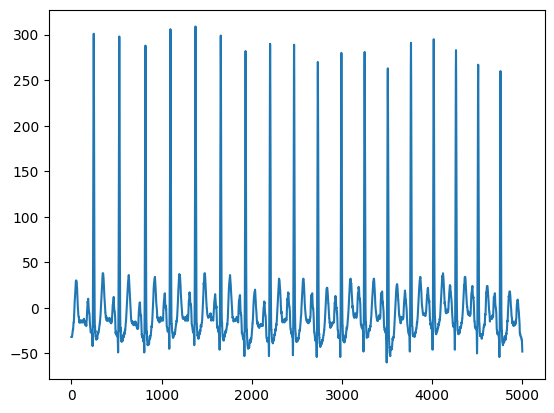

In [4]:
#Just for testing:
# #Load the data from the numpy file

loaded_data = np.load(os.path.join(np_folder,np_file_name), allow_pickle=True)
#Plot the voltage data for lead II
import matplotlib.pyplot as plt
plt.plot(all_leads['II'])
plt.show()
